In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import time
%matplotlib inline

In [2]:
dataset = pd.read_csv('./winequality.csv')
dataset

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


## Winedataset
The problem of predicting quality given the wine features is a regression problem:
* because the output (i.e., quality) is continuous 
Quality is an ordinal, that is

$$
0 \leq 1 \leq 2 \leq \dots \leq 6
$$

a 5-quality wine is 
* better than a 4-quality wine and 
* worse than a 6-quality wine.

That's the reason we formulated the problem as a regression problem, we want to predict numerical values. 
Linear regression could predict a quality that is 5.1 (even if fractional qualities are not in the dataset) and it means that wine is slightly better than a 5-quality wine.

Let's now imagine we want  to consider quality a **categorical variable**, that is

$$
0,1,2,3,4,5,6
$$

are classes. This problem then becomes a classification problem
* because the output (i.e., quality) is discrete

**Question:**

Can we use MultinomialNB to predict the quality-class given the wine-characteristics?

No because wine-characteristics are continuous variables abd MultinomialNB only accepts counts.

For instance, in the gender-name example, we had to use this encoding

$$
\begin{aligned}
a &\rightarrow & [1,0,\dots,0]\\
b &\rightarrow & [0,1,\dots,0]\\
... & ... & ....
\end{aligned}
$$

so the dataset $\{(a,1),(b,1)\}$ is encoded into

$$
\begin{aligned}
1,0,0,\dots,0,1\\
0,1,0,\dots,0,1\\
\end{aligned}
$$

where the last column is the class variable (gender).

## Discretisation and encoding

We can discretise a continuous variables by using bins (interval). Consider for instance

In [3]:
fixed_ac = dataset['fixed acidity'].values
print(fixed_ac)
print(np.min(fixed_ac),np.max(fixed_ac))

[7.4 7.8 7.8 ... 6.3 5.9 6. ]
4.6 15.9


We can split the interval $[4.6, 15.9]$ in five equally spaced intervals, e.g.,

$$
[ 4.6 ,  6.86], ~~[6.86,  9.12], ~~[9.12, 11.38], ~~[11.38,13.64], ~~[13.64, 15.9 ]
$$

and we can consider these five intervals as five classes.
This is what we do for instance when we plot histograms.

(array([274., 913., 298., 102.,  12.]),
 array([ 4.6 ,  6.86,  9.12, 11.38, 13.64, 15.9 ]),
 <a list of 5 Patch objects>)

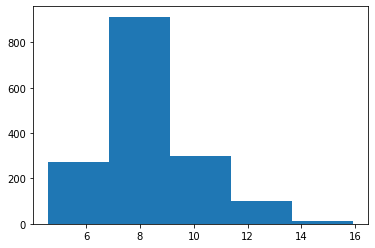

In [4]:
#Biining a continuous variable
plt.hist(fixed_ac,bins=5)

There is a faster way to that using a function called `KBinsDiscretizer` from `sklearn` library

In [5]:
X = fixed_ac.reshape(-1,1)
print(X)
from sklearn.preprocessing import KBinsDiscretizer
est = KBinsDiscretizer(n_bins=5,encode='ordinal',strategy='uniform')
est.fit(X)
X_d = est.transform(X)
X_d

[[7.4]
 [7.8]
 [7.8]
 ...
 [6.3]
 [5.9]
 [6. ]]


array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [6]:
est.inverse_transform(X_d)

array([[7.99],
       [7.99],
       [7.99],
       ...,
       [5.73],
       [5.73],
       [5.73]])

In [7]:
print(est.inverse_transform(np.array([[0]])))
print(est.inverse_transform(np.array([[1]])))
print(est.inverse_transform(np.array([[2]])))
print(est.inverse_transform(np.array([[3]])))
print(est.inverse_transform(np.array([[4]])))

[[5.73]]
[[7.99]]
[[10.25]]
[[12.51]]
[[14.77]]


Note that in order to apply MultinomialNB we need
1. to discretize the variables in 5 categories (0,1,2,3,4)
2. to encode the 5 categories

$$
\begin{aligned}
0 &\rightarrow & [1,0,0,0,0]\\
1 &\rightarrow & [0,1,0,0,0]\\
2 &\rightarrow & [0,0,1,0,0]\\
3 &\rightarrow & [0,0,0,1,0]\\
4 &\rightarrow & [0,0,0,0,1]\\
\end{aligned}
$$

We can do it in one-shot by using `KBinsDiscretizer(n_bins=5,encode='onehot',strategy='uniform')`
In this way, the inputs are already in the right format for MultinomialNB.

In [8]:
X = fixed_ac.reshape(-1,1)
from sklearn.preprocessing import KBinsDiscretizer
est = KBinsDiscretizer(n_bins=5,encode='onehot',strategy='uniform')
est.fit(X)
X_d = est.transform(X)
X_d

<1599x5 sparse matrix of type '<class 'numpy.float64'>'
	with 1599 stored elements in Compressed Sparse Row format>



`Xd_train` is saved as a sparse-matrix so we do not need to save all the zeros and in this way we save memory
space. If we want to see it, we can transform it back to a normal (dense) matrix with the following instruction

In [9]:
#we can transforma sparse matrix into a normal matrix as:
X_d.todense()

matrix([[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        ...,
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]])

## Step1: we divide the dataset in training and testing

In [10]:
#we split the dataset in training and testing
X=dataset.iloc[:,0:-1].values
y=dataset.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
print(X_train.shape)
print(X_test.shape)

(959, 11)
(640, 11)


## Step2: we discretize the inputs in the training dataset

In [11]:
est = KBinsDiscretizer(n_bins=5,encode='onehot',strategy='uniform')
est.fit(X_train)
Xd_train = est.transform(X_train)
Xd_train


<959x55 sparse matrix of type '<class 'numpy.float64'>'
	with 10549 stored elements in Compressed Sparse Row format>

## Step3: we discretize the inputs in the test dataset

In [12]:
Xd_test  = est.transform(X_test)

Note that we  **don't do**

`est = KBinsDiscretizer(n_bins=10,encode='onehot',strategy='quantile')
est.fit(X_test)
Xd_test = est.transform(X_test)
Xd_train`

A discretisation algorithm is a ML algorithm and, therefore, we do `fit` only on the training dataset and we only transform the test dataset. Otherwise, we could risk overfitting.

This is a **general approach**. 

## Step 4: MultinomialNB

In [13]:
## General ML Recipe algorithm
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB() # 

#training
clf.fit(Xd_train, y_train)

y_train_pred = clf.predict(Xd_train)
y_test_pred  = clf.predict(Xd_test)

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix
print("accuracy training set ", accuracy_score(y_train,y_train_pred))
print("accuracy test set ",accuracy_score(y_test,y_test_pred))

accuracy training set  0.5901981230448383
accuracy test set  0.5640625


In [15]:
print("Confusion Matrix test set ")
confusion_matrix(y_test,y_test_pred)

Confusion Matrix test set 


array([[  0,   1,   1,   0,   0,   0],
       [  0,   2,  11,  10,   0,   0],
       [  0,   1, 190,  78,   7,   2],
       [  0,   1,  88, 126,  32,   1],
       [  0,   0,   5,  32,  43,   1],
       [  0,   0,   0,   4,   4,   0]])

## Question 
How do we select the number of bins in `KBinsDiscretizer(n_bins=7,encode='onehot',strategy='quantile')`?

Is there an optimal way (the discretisation that gives us the highest accuracy on the test set)?

To answer this question we can use 10-folds cross-validation. This will help us
to avoid overfitting. We select the value n_bins that provides the highest accuracy.



In [16]:
from IPython.display import Image
Image("CV.png")

The following loop computes the 10-fold cross-validation accuracy for a fixed value of `n_bins`

In [22]:
from sklearn.model_selection import KFold, cross_val_score
n_bins = 4
k_fold = KFold(n_splits=10,  shuffle=True, random_state=42)
Accuracy=[]
for train_indices, test_indices in k_fold.split(X):
    #print('Train: %s | test: %s' % (train_indices, test_indices))
    X_train, X_test, y_train, y_test =X[train_indices], X[test_indices], y[train_indices], y[test_indices]
    #discretise
    est = KBinsDiscretizer(n_bins=n_bins,encode='onehot',strategy='uniform')
    est.fit(X_train)
    Xd_train = est.transform(X_train)
    Xd_test  = est.transform(X_test)
    clf = MultinomialNB() 
    #training
    clf.fit(Xd_train, y_train)
    #prediction
    y_test_pred  = clf.predict(Xd_test)
    #accuracy
    Accuracy.append(accuracy_score(y_test,y_test_pred))
    
print("Average 10-fold cross-validation accuracy=",np.mean(np.array(Accuracy)))

Average 10-fold cross-validation accuracy= 0.5660062893081761


### Exercise 1
Implement a for-loop that tries all the values of `n_bins` in the  `range(2,20)`  and
selects the value `n_bins` corresponding to the highest  best **Average 10-fold cross-validation accuracy**.

## Logistic Regression classifier

Can we use a classifier than doesn't need discretisation?
Equivalently, can we use directly continuous inputs without discretisation?


Logistic Regression classifier is the simplest neural network. It is a classifier that directly accepts
continuous inputs. We will go into details during the lecture on Monday; we will use it now as a blackbox model,
that is without going into details of the algorithm.

Note that, although is called **Logistic Regression** it is actually  a classifier.

In [18]:
from sklearn.linear_model import LogisticRegression

#we split the dataset in training and testing
X=dataset.iloc[:,0:-1].values
y=dataset.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

#Logistic
clf  = LogisticRegression(solver='lbfgs', multi_class='multinomial')#'multinomial' here means that the class
                                                                   #has more than two categories
clf.fit(X_train,y_train)
y_train_pred2= clf.predict(X_train)
y_test_pred2 = clf.predict(X_test)

/home/shravan/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [19]:
print("accuracy training set ", accuracy_score(y_train_pred2,y_train))
print("accuracy test set ",accuracy_score(y_test_pred2,y_test))

accuracy training set  0.5922836287799792
accuracy test set  0.5546875


## Solving the convergence problem by normalsing the inputs
When you run LogisticRegression you have this warning

`...python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
`

This is a numerical problem, the optimiser lbfgs, that numerically maximises the likelihood to find the MLE, is not converging (more details on Monday). 

This is a common problem in ML. A way to help lbfgs is by scaling the inputs.

In [20]:
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler()
scalerX.fit(X_train)
X_tr_scaled = scalerX.transform(X_train)
X_te_scaled = scalerX.transform(X_test)

The standard scaler normalize the data, that is for each column in X_train does the following

`
(X_train[:,i]-np.mean(X_train[:,i]))/np.std(X_train[:,i])
`

where `mean` computes the mean and `std` the standard deviation of the column.

Example: assume the data is $[10,50,35,20]$, then 

$$
mean=\frac{10+50+35+20}{4}=28.75
$$

and

$$
std=\sqrt{\frac{(10-28.75)^2+(50-28.75)^2+(35-28.75)^2+(20-28.75)^2}{4}}=1.5155
$$

and so the transformed data is

$$
\frac{[10,50,35,20]-28.75}{15.155}=[-1.23717915,  1.40213637,  0.41239305, -0.57735027]
$$

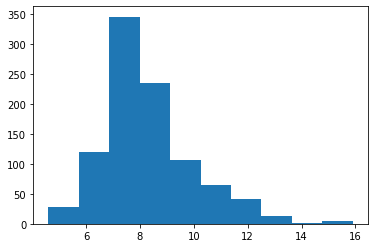

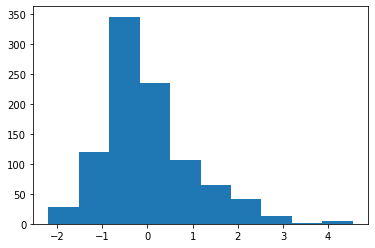

In [21]:
col=0
#before
plt.hist(X_train[:,col]);
plt.figure()
#after
plt.hist(X_tr_scaled[:,col]);

In [73]:
from sklearn.linear_model import LogisticRegression

clf  = LogisticRegression(solver='lbfgs', multi_class='multinomial')#'multinomial' here means that the class
                                                                   #has more than two categories
clf.fit(X_tr_scaled,y_train)
y_train_pred2= clf.predict(X_tr_scaled)
y_test_pred2 = clf.predict(X_te_scaled)
print("accuracy training set ", accuracy_score(y_train_pred2,y_train))
print("accuracy test set ",accuracy_score(y_test_pred2,y_test))

accuracy training set  0.6308654848800834
accuracy test set  0.56875


Now  the classifier has  a better perfomance, because lbfgs computed a better solution (We will go into details on Monday).

Is scaling+LogisticRegression better than discretisation + MultinomialNB?


### Exercise 2
Use 10-fold cross validation to compare the performance of the two classifiers. 

### Exercise 3

Business Problem: Banks receives so many applications for credit card (CC) request. Going through each request manually can be very time consuming, also prone to human errors. However, if we can use the historical data to build a model which can shortlist the candidates for approval that save time.

By using the previous two classifiers, you must build a predictor model that predicts if a CC should be approved
for a person that has certain characteristics (sex,age,Debt, Married etc.)


In [79]:
df = pd.read_csv("datasets/CreditCard_cleanedData.csv")
df

,Male,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,Citizen,Income,Approved
0,1,30.83,0.000,1,0,12,7,1.250,1,1,1,0,0,0
1,0,58.67,4.460,1,0,10,3,3.040,1,1,6,0,560,0
2,0,24.50,0.500,1,0,10,3,1.500,1,0,0,0,824,0
3,1,27.83,1.540,1,0,12,7,3.750,1,1,5,0,3,0
4,1,20.17,5.625,1,0,12,7,1.710,1,0,0,2,0,0
5,1,32.08,4.000,1,0,9,7,2.500,1,0,0,0,0,0
6,1,33.17,1.040,1,0,11,3,6.500,1,0,0,0,31285,0
7,0,22.92,11.585,1,0,2,7,0.040,1,0,0,0,1349,0
8,1,54.42,0.500,2,2,8,3,3.960,1,0,0,0,314,0
9,1,42.50,4.915,2,2,12,7,3.165,1,0,0,0,1442,0


In [80]:
# Creating new variable to input features and labels
X,y = df.iloc[:,0:13].values , df.iloc[:,13].values

## Solution

Exercise 1:
the best model is n_bins = 7



In [23]:
from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=10)
Accuracy_Fold=[]
for n_bins in range(2,20):
    Accuracy=[]
    for train_indices, test_indices in k_fold.split(X):
        #print('Train: %s | test: %s' % (train_indices, test_indices))
        X_train, X_test, y_train, y_test =X[train_indices], X[test_indices], y[train_indices], y[test_indices]
        #discretise
        est = KBinsDiscretizer(n_bins=n_bins,encode='onehot',strategy='uniform')
        est.fit(X_train)
        Xd_train = est.transform(X_train)
        Xd_test  = est.transform(X_test)
        clf = MultinomialNB() 
        #training
        clf.fit(Xd_train, y_train)

        #prediction
        y_test_pred  = clf.predict(Xd_test)
        #accuracy
        Accuracy.append(accuracy_score(y_test,y_test_pred))
    #print("Average 10-fold cross-validation accuracy=",np.mean(np.array(Accuracy)))
    Accuracy_Fold.append([n_bins,np.mean(np.array(Accuracy))])
Accuracy_Fold=np.array(Accuracy_Fold)
print(Accuracy_Fold)
ind=np.argmax(Accuracy_Fold[:,1])
print("Best n_bins=",Accuracy_Fold[ind,:])

[[ 2.          0.51090016]
 [ 3.          0.53285377]
 [ 4.          0.55407233]
 [ 5.          0.55155267]
 [ 6.          0.54847091]
 [ 7.          0.56910377]
 [ 8.          0.55595519]
 [ 9.          0.56159984]
 [10.          0.55720519]
 [11.          0.55660377]
 [12.          0.55720519]
 [13.          0.56722484]
 [14.          0.56784591]
 [15.          0.55156447]
 [16.          0.56533805]
 [17.          0.54782626]
 [18.          0.55032626]
 [19.          0.5559316 ]]
Best n_bins= [7.         0.56910377]


### Exercise 2: 

In [ ]:


from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=10)
n_bins = 7

Accuracy_MNB=[]
Accuracy_Logistic=[]
for train_indices, test_indices in k_fold.split(X):
    #print('Train: %s | test: %s' % (train_indices, test_indices))
    X_train, X_test, y_train, y_test =X[train_indices], X[test_indices], y[train_indices], y[test_indices]
    #discretise
    est = KBinsDiscretizer(n_bins=n_bins,encode='onehot',strategy='uniform')
    est.fit(X_train)
    Xd_train = est.transform(X_train)
    Xd_test  = est.transform(X_test)
    clf = MultinomialNB() 
    #training
    clf.fit(Xd_train, y_train)
    #prediction
    y_test_pred  = clf.predict(Xd_test)
    #accuracy
    Accuracy_MNB.append(accuracy_score(y_test,y_test_pred))
    
    scalerX = StandardScaler()
    scalerX.fit(X_train)
    X_tr_scaled = scalerX.transform(X_train)
    X_te_scaled = scalerX.transform(X_test)
    
    clf  = LogisticRegression(solver='lbfgs', multi_class='multinomial')#'multinomial' here means that the class
                                                                    #has more than two categories
    clf.fit(X_tr_scaled,y_train)

    y_test_pred_logistic = clf.predict(X_te_scaled)
    Accuracy_Logistic.append(accuracy_score(y_test,y_test_pred_logistic))
    
print("Average 10-fold cross-validation accuracy MultinomialNB=",np.mean(np.array(Accuracy_MNB)))
print("Average 10-fold cross-validation accuracy Logistic=",np.mean(np.array(Accuracy_Logistic)))

Exercise 3 (same solution has before, but one should first select the optimal number of bins
as in Exercise 1)

In [81]:
from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=10)
n_bins = 7

Accuracy_MNB=[]
Accuracy_Logistic=[]
for train_indices, test_indices in k_fold.split(X):
    #print('Train: %s | test: %s' % (train_indices, test_indices))
    X_train, X_test, y_train, y_test =X[train_indices], X[test_indices], y[train_indices], y[test_indices]
    #discretise
    est = KBinsDiscretizer(n_bins=n_bins,encode='onehot',strategy='uniform')
    est.fit(X_train)
    Xd_train = est.transform(X_train)
    Xd_test  = est.transform(X_test)
    clf = MultinomialNB() 
    #training
    clf.fit(Xd_train, y_train)
    #prediction
    y_test_pred  = clf.predict(Xd_test)
    #accuracy
    Accuracy_MNB.append(accuracy_score(y_test,y_test_pred))
    
    scalerX = StandardScaler()
    scalerX.fit(X_train)
    X_tr_scaled = scalerX.transform(X_train)
    X_te_scaled = scalerX.transform(X_test)
    
    clf  = LogisticRegression(solver='lbfgs', multi_class='multinomial')#'multinomial' here means that the class
                                                                    #has more than two categories
    clf.fit(X_tr_scaled,y_train)

    y_test_pred_logistic = clf.predict(X_te_scaled)
    Accuracy_Logistic.append(accuracy_score(y_test,y_test_pred_logistic))
    
print("Average 10-fold cross-validation accuracy MultinomialNB=",np.mean(np.array(Accuracy_MNB)))
print("Average 10-fold cross-validation accuracy Logistic=",np.mean(np.array(Accuracy_Logistic)))

Average 10-fold cross-validation accuracy MultinomialNB= 0.8391304347826087
Average 10-fold cross-validation accuracy Logistic= 0.8405797101449277
